# PHXS 491_001: Observational Astronomy - Homework 4

### Due Sep 28, 2021
Remember to save your completed notebook as a PDF and upload to Brightspace under Assignments.

Name: William Jardee

## Please use the "primt()" function (notice the "m") to print out your answers in magenta.  This makes grading easier.  You might need to "print to PDF" to get the colors to show up. Thanks to Katie for figuring this out.

In [4]:
# # Chaning theme to a light mode for printing
# import jupyterthemes as jt
# !jt -t grade3 -T -N -kl -nfs 11 -fs 11 -ofs 11 -cursc r -cellw 90%
# jt.jtplot.style()
# jt.get_themes()

In [5]:
def primt(*args):
    '''
    For any amount of arguments "*args", prints in magenta.
    '''
    magenta = "\x1B[38;5;201m"   # the color in ANSI code
    string = ""
    for el in args:  # for each argument
        string += " "+(str(el))  # add the argument to the string to be printed
    magenta += string[1:]
    print(magenta)   #print!

In [6]:
#Bring in our imports
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from matplotlib import pyplot as pl
import matplotlib.pyplot as plt
import astropy.units as u
from uncertainties import ufloat
from astropy.io import fits
%matplotlib inline


# Part 1. Airmass and seeing

Seeing increases (worsens) with increasing zenith distance given the increased path length through the atmosphere.  The seeing depends on airmass as: $s = s_0 X^{3/5}$

1) What is the airmass of a star with DEC=+70.0 deg as it passes through the meridian when observed from Bozeman (latitude=45.6770 deg)

In [34]:
z = ((70-45.6770) * u.deg).to(u.radian)
X = 1/np.cos(z)
primt(f"We have {X:.2f} airmasses")

We have 1.10 airmasses


2) Will it's airmass be larger or smaller as the star moves away from the meridian?

In [35]:
primt('Since it is now moving further from us, there will be more air obstructing our vision: more airmass.')

Since it is now moving further from us, there will be more air obstructing our vision: more airmass.


3) What is the minimum airmass of a star with DEC=-10.0 deg (observed from Bozeman)?

In [9]:
z = ((-10-45.6770) * u.deg).to(u.radian)
X = 1/np.cos(z)
primt(f"We have {X:.2f} airmasses")

We have 1.77 airmasses


4) The seeing is observed to be 1.5 arcsec at a zenith distance of 30 deg.  What is the expected seeing at a zenith distance of 70 deg?

In [10]:
z = ((30) * u.deg).to(u.radian)
X = 1/np.cos(z)
s_0 = 1.5*u.arcsec*X**(-3/5)

z = ((70) * u.deg).to(u.radian)
X = 1/np.cos(z)
s = s_0* X**(3/5)
primt(f"Expected seeing of {s:.2f}")

Expected seeing of 2.62 arcsec


5) Seeing varies with wavelength as $\lambda^{-1/5}$.  If the seeing is 1.0 arcsec at 500 nm, what is the seeing at 1.5 $\mu$m.

In [11]:
# s = s_0 * lambda^(-1/5)
s_0 = 1.0*u.arcsec * ((500.0)*u.nm)**(1/5)
s = s_0 * (1.5*u.micrometer)**(-1/5)
primt(f"Seeing: {s.decompose().to(u.arcsec):.2f}")

Seeing: 0.80 arcsec


# Part 2: Fitting Data
In this section we will look at some of the basic ideas and issues associated with fitting data.

## Fitting Lines and Polynomials
Fitting linear functions can be done in an exact way using a number of linear algebra techniques. This suite of algorithms is called linear least-squares fitting. Most of these techniques assume that the error in y is signficant and that the error in x is not. Numpy has a very useful method for this called polyfit.

## An Example of a Line
This is a line $y=mx+b$ where $m = 1.3$ $b=-2.7$ with variable error bars added on. 
Let's Create our Data Set

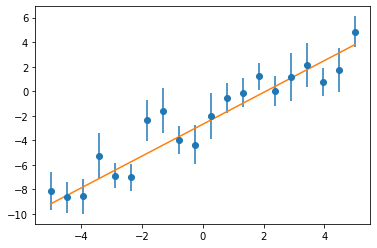

In [12]:
#Create Some data
np.random.seed(100) #Seed the random number generator, so the result is always the same
num = 20
x=np.linspace(-5,5,num) #Create a evenly spaced set of data points
m= 1.3
b = -2.7
theory_y = m*x + b #Let's make a line

yerr = np.random.rand(num) + 1 #I want a series of sigmas between 1 and 2
y = yerr * np.random.standard_normal(num) + theory_y #Move my y values by the error

plt.errorbar(x, y, yerr=yerr,fmt='o')
plt.plot(x, theory_y)

## Polyfit
Polyfit is very good for fitting lines or polynomials. Inputs are np.polyfit(x,y,degree,w=weights). Where weight is equal to 1/sigma. Returns the coefficients of the fit highest power first. You can use np.polyval() to plot the results.

m= 1.289 b= -2.538


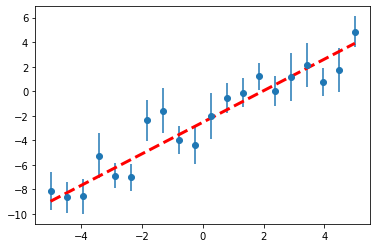

In [13]:
(param,cov) = np.polyfit(x,y,1,w=1/yerr,cov=True)
fitp = np.poly1d(param)
yfit = fitp(x)
plt.errorbar(x, y, yerr=yerr,fmt='o')
plt.plot(x, yfit,'r--',lw=3)
print("m= {:.3f} b= {:.3f}".format(param[0],param[1]))

## Covariance and Correlation Matrices
Now we would like an estimate of how good our parameter estimation is. In order to do this we need what is called the error or covariance matrix. The covariance matrix is a square, symmetric matrix that is constructed from the variances in each parameter. 

For a 2 parameter ($p_1,p_2$) fit: $cov = \begin{bmatrix} \sigma_{p_1}^2 & \sigma_{p_1p_2}^2 \\ \sigma_{p_2p_1}^2 & \sigma_{p_2}^2 \\ \end{bmatrix}$ Where $\sigma_{p_jp_k}^2 = covariance(p_j,p_k)$ The diagonal gives us the variance in each parameter.

The correlation matrix tells you how correlated each variable is: $cor = \begin{bmatrix} \frac{\sigma_{p_1}^2}{\sigma_{p_1}\sigma_{p_1}} & \frac{\sigma_{p_1p_2}^2}{\sigma_{p_1}\sigma_{p_1}} \\ \frac{\sigma_{p_1p_2}^2}{\sigma_{p_1}\sigma_{p_2}}& \frac{\sigma_{p_2}^2}{\sigma_{p_2}\sigma_{p_2}} \\ \end{bmatrix}$ 

It is normalized to run from -1 to 1, with -1 being completely anti-correlated, 0 not correlated, and 1 being completely correlated.

In [14]:
def cov2cor(cov):
    #Need to fix for any dimension
    n = len(cov[0])
    if n == 2:
        diag = np.sqrt(np.diag(cov))
        a = np.vstack((diag,diag))
        b = diag.reshape(2,1)
        c = np.hstack((b,b)) * a
    else:
        diag = np.sqrt(np.diag(cov))
        a = np.vstack((diag,diag,diag))
        b = diag.reshape(3,1)
        c = np.hstack((b,b,b)) * a
    inv = 1/c
    return(inv * cov)

print("Covariance Matrix: ")
print(cov)
cor = cov2cor(cov)
print("Correlation Matrix: ")
print(cor)
print("m= {:.3f} +/- {:.3f}\nb= {:.3f} +/- {:.3f}".format(param[0],np.sqrt(cov[0,0]),param[1],np.sqrt(cov[1,1])))

Covariance Matrix: 
[[0.00901258 0.00047977]
 [0.00047977 0.07971502]]
Correlation Matrix: 
[[1.         0.01789949]
 [0.01789949 1.        ]]
m= 1.289 +/- 0.095
b= -2.538 +/- 0.282


We can see that our variables are not very correlated.

## How Good is Our Fit?
Our line goes through the points, but can we quantify how good our fit is? If we know our what our answer is, we can use Percent error $\frac{|Theory-Observed|}{Theory} \times 100\%$ 

In [15]:
print("Percent Error: m: {:.1%} b: {:.1%}".format(np.abs((param[0]-m)/m), np.abs((param[1]-b)/b)))

Percent Error: m: 0.8% b: 6.0%


In general, however, we have to use the data we have in order to evaluate the quality of the fit. The first thing we can do is look at the residual of our fit by subtracting our observed y values from the fitted y values. Then we take the standard deviation. This is called the Root Mean Squared error or RMS error. 

In [16]:
rms = np.std(yfit - y)
print("RMS: {:.3f}".format(rms))

RMS: 1.275


We can use this RMS as a systemic error. If we use our fitted relation to make preditictions for y values based on x values, we know that $\sigma_{sys}$ is always there of 1.275.

The RMS method that we used can't tell us how good our fit is compared to how good it should be based on the y-errors. We fundamentallly want to know whether this is a "good" fit or not.

The standard method used in astronomy to determine a good fit is the $\chi^2$ metric. $\chi^2 = \sum_{i=1}^{N} \left[ \frac{y_{obs,i} - y_{fit,i}}{\sigma_i}\right]^2$

In [17]:
chi = np.sum(((y - yfit)/yerr)**2)
print("Chisq: {:.3f}".format(chi))

Chisq: 15.503


The quality of your chisq fit is a function of both the number of fitted parameters and the number of data points. The more data points the better the fit. The more parameters the easier it is to fit data. We encapsulate both with the concept of degrees of freedom $f = n - p$ where $n$ is the number of points and $p$ is the number of fitted parameters. We can then compare fits of different numbers of data points and parameters by looking at a statistic called the **reduced chi squared**, $\chi_{\nu}^2 = \frac{\chi^2}{f}$. A reduced chi-squared near 1 is a good fit. 

To determine how good it is we can determine the p-value (probability) that a higher reduced chi-squared could due to random noise. A p-value of between 0.1 and 0.9 is good. If the p_value is greater than 0.98 then your error bars are too big and if your p_value is less than 0.02 then your error bars are too small.

In [18]:
dof = len(y) - len(param)
redchi = chi/dof
print("Red Chisq: {:.3f} Dof: {}".format(redchi,dof))
p_value = 1 - stats.chi2.cdf(chi, df=dof)
print("P-Value: {:.3f}".format(p_value))

Red Chisq: 0.861 Dof: 18
P-Value: 0.627


In real life, our errors are often under or over estimated. For example let's say that our error bars where underestimated by a factor of 1.5.

In [19]:
byerr = yerr/1.5
(bparam,bcov) = np.polyfit(x,y,1,w=1/byerr,cov=True)
bfitp = np.poly1d(bparam)
byfit = bfitp(x)
bchi = np.sum(((y - byfit)/byerr)**2)
bdof = len(y) - len(param)
bredchi = bchi/bdof
bp_value = 1 - stats.chi2.cdf(bchi, df=bdof)
print("m= {:.3f} +/- {:.3f}\nb= {:.3f} +/- {:.3f}".format(bparam[0],np.sqrt(bcov[0,0]),bparam[1],np.sqrt(bcov[1,1])))
print("Chisq: {:.3f}".format(bchi))
print("Red Chisq: {:.3f} Dof: {}".format(bredchi,bdof))
print("P-Value: {:.3f}".format(bp_value)) 

m= 1.289 +/- 0.095
b= -2.538 +/- 0.282
Chisq: 34.882
Red Chisq: 1.938 Dof: 18
P-Value: 0.010


Notice that our fit values and errors stay the same, but our chisq is significantly different. *Note: The values and errors only stay the same because our error bars are off by a constant multiple.* Our pvalue is less than 0.02 so our error bars are too small, as we already knew.

## Exploring Chi Square Space
We can calculate chi square values at many points and get a sense of what the chi square space looks like

In [20]:
#Do This for our line
mstep = 100
bstep = 100
b_step = np.linspace(-5,5,bstep)
m_step = np.linspace(-5,5,mstep)
b_arr = np.zeros(mstep*bstep)
m_arr = np.zeros(mstep*bstep)
chi_arr = np.zeros(mstep*bstep)
param = np.zeros(2)
perr = np.zeros(2)

k = 0
for i in range(len(m_step)):
    for j in range(len(b_step)):
        m_arr[k] = m_step[i]
        b_arr[k] = b_step[j]
        testy = m_arr[k]*x + b_arr[k]
        chi_arr[k] = np.sum(((y - testy)/yerr)**2)
        k=k+1

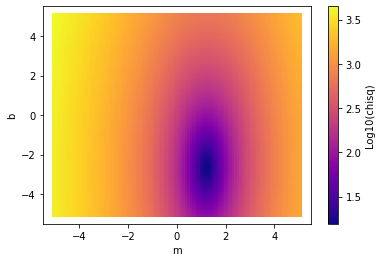

In [21]:
plt.scatter(m_arr,b_arr,c=np.log10(chi_arr),cmap=plt.cm.plasma,marker='s',edgecolor='none')
plt.xlabel("m")
plt.ylabel("b")
plt.colorbar(label="Log10(chisq)")

The chi square space is really well behaved, not surprisingly. The closer we are to the right answer in either m or b, the better our chi square.

## Now it is your turn
Let's fit the following polynomial $ax^2+bx+c$ where $a = 1.3$, $b= -3.7$, and $c=2.2$

In [22]:
#Create Some data
np.random.seed(200) #Seed the random number generator, so the result is always the same
num = 20
x=np.linspace(-5,5,num) #Create a evenly spaced set of data points
a = 1.3
b = -3.7
c = 2.2
theory_y = a*x**2 + b*x + c #Let's make a line

yerr = np.random.rand(num) + 1 #I want a series of sigmas between 1 and 2
y = yerr * np.random.standard_normal(num) + theory_y #Move my y values by the error

Now you fit the data give me the values and errors for a, b, c. Also compute the $\chi^2$, $\chi_{\nu}^2$, and p-value.

a= 1.356+/-0.047
b= -3.798+/-0.115
c= 2.004+/-0.585
Chisq: 20.053
Red Chisq: 1.180 Dof: 17
P-Value: 0.272


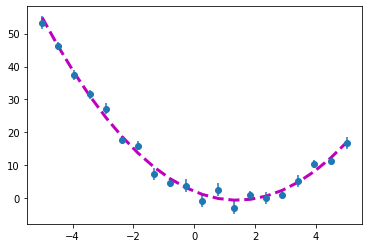

In [23]:
# Quadratic line fitting
(param,cov) = np.polyfit(x,y,2,w=1/yerr,cov=True)
fitp = np.poly1d(param)
yfit = fitp(x)

plt.errorbar(x, y, yerr=yerr,fmt='o')
plt.plot(x, yfit,'m--',lw=3)

a = ufloat(param[0],np.sqrt(cov[0,0]))
b = ufloat(param[1],np.sqrt(cov[1,1]))
c = ufloat(param[2],np.sqrt(cov[2,2]))
primt(f"a= {a:.3f}\n" +
      f"b= {b:.3f}\n" +
      f"c= {c:.3f}")

# Calculating Chi
chi = np.sum(((y - yfit)/yerr)**2)
primt("Chisq: {:.3f}".format(chi))

# Calculating Chi squarted
dof = len(y) - len(param)
redchi = chi/dof
primt("Red Chisq: {:.3f} Dof: {}".format(redchi,dof))

# Calculating p-value
p_value = 1 - stats.chi2.cdf(chi, df=dof)
primt("P-Value: {:.3f}".format(p_value))

## Non-linear Functions
The concepts that we discussed for linear functions also applies to non-linear functions. However the algorithms we use to find these values are much more prone to finding the wrong answer. One class of fitting algorithms are called non-linear least squares fitters.

## Let's Make Some Data
Let's create sine curve: $Amp\sin(\frac{2 \pi x}{period})$

<ErrorbarContainer object of 3 artists>

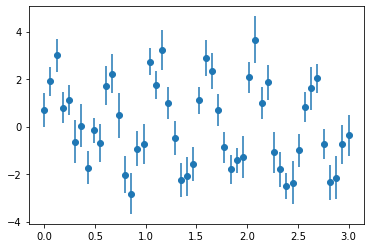

In [24]:
#Create Some data
def mysine(x,amp,period):
    return (amp * np.sin(2*np.pi*x/period))

np.random.seed(300) #Seed the random number generator, so the result is always the same
num = 50
x=np.linspace(0,3,num) #Create a evenly spaced set of data points
amp = 2.1
period = 0.5

theory_y = mysine(x,amp,period)

yerr = 0.5*np.random.rand(num) + 0.5 #I want a series of sigmas between 0.5 and 1
y = yerr * np.random.standard_normal(num) + theory_y #Move my y values by the error

plt.errorbar(x, y, yerr=yerr,fmt='o')

## We can do this the easy way or the hard way...Looks like it is going to be the hard way.
For non-linear equations the only way to be 100% sure that you've covered chi squared space is to do a grid search. How the grid search works is that you calculate the chi squared statistic at all the values to some resolution for each of your parameters. The parameter set that has the lowest chi squared is your value. Unfortunately, for most problems a normal grid search is too computationally expensive to do very often.

In [25]:
astep = 100
pstep = 100
amp_step = np.linspace(0,4,astep)
period_step = np.linspace(.02,2,pstep)
amp_arr = np.zeros(astep*pstep)
period_arr = np.zeros(astep*pstep)
chi_arr = np.zeros(astep*pstep)
param = np.zeros(2)
perr = np.zeros(2)

k = 0
for i in range(len(amp_step)):
    for j in range(len(period_step)):
        amp_arr[k] = amp_step[i]
        period_arr[k] = period_step[j]
        testy = mysine(x,amp_arr[k],period_arr[k])
        chi_arr[k] = np.sum(((y - testy)/yerr)**2)
        k=k+1
#Find minimum chi square
minidx = np.argmin(chi_arr)

param[0] = amp_arr[minidx]
param[1] = period_arr[minidx]
chi = chi_arr[minidx]
yfit = mysine(x,param[0],param[1])
perr[0] = amp_step[1] - amp_step[0] #Get a step size
perr[1] = period_step[1] - period_step[0] #Get a step size 

In [26]:
#Note these are not Gaussian errors, only step sizes
print("amp= {:.3f} +/- {:.3f}\nperiod= {:.3f} +/- {:.3f}".format(param[0],perr[0],param[1],perr[1]))
chi = np.sum(((y - yfit)/yerr)**2)
print("Chisq: {:.3f}".format(chi))
dof = len(y) - len(param)
redchi = chi/dof
print("Red Chisq: {:.3f} Dof: {}".format(redchi,dof))
p_value = 1 - stats.chi2.cdf(chi, df=dof)
print("P-Value: {:.3f}".format(p_value))

amp= 2.222 +/- 0.040
period= 0.500 +/- 0.020
Chisq: 65.573
Red Chisq: 1.366 Dof: 48
P-Value: 0.047


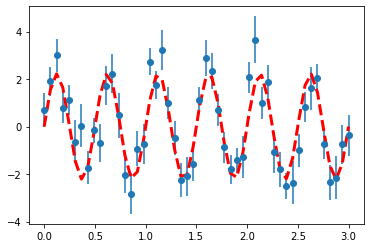

In [27]:
plt.errorbar(x, y, yerr=yerr,fmt='o')
plt.plot(x, yfit,'r--',lw=3)

## Let's Look at Chi Square Space 

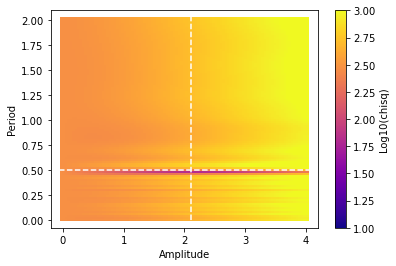

In [28]:
plt.scatter(amp_arr,period_arr,c=np.log10(chi_arr),cmap=plt.cm.plasma,marker='s',edgecolor='none')
plt.xlabel("Amplitude")
plt.ylabel("Period")
plt.clim(1,3)
plt.colorbar(label="Log10(chisq)")
plt.axvline(2.1,color='w',linestyle='--')
plt.axhline(0.5,color='w',linestyle='--')

Let's Zoom in.

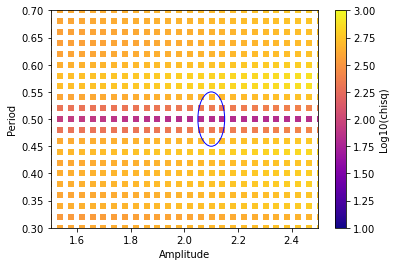

In [29]:
plt.scatter(amp_arr,period_arr,c=np.log10(chi_arr),cmap=plt.cm.plasma,marker='s',edgecolor='none')
plt.xlabel("Amplitude")
plt.ylabel("Period")
plt.clim(1,3)
plt.xlim(1.5,2.5)
plt.ylim(0.3,0.7)
plt.colorbar(label="Log10(chisq)")
circle = plt.Circle((2.1,0.5), 0.05, color='b', fill=False)
plt.gcf().gca().add_artist(circle)

This is a very different chi square space than the line fit above. If you start at the wrong period, you will not find your way to the right one. Also it is also clear that the amplitude has trouble finding the right answer when the period is wrong.

## Curve_fit

In [30]:
(param,cov) = curve_fit(mysine,x,y,p0=[100,.51],sigma=yerr)
yfit = mysine(x,param[0],param[1])
perr = np.sqrt(np.diag(cov))

In [31]:
print(cov)
cor =cov2cor(cov)
print(cor)
print("amp= {:.3f} +/- {:.3f}\nperiod= {:.3f} +/- {:.3f}".format(param[0],perr[0],param[1],perr[1]))
chi = np.sum(((y - yfit)/yerr)**2)
print("Chisq: {:.3f}".format(chi))
dof = len(y) - len(param)
redchi = chi/dof
print("Red Chisq: {:.3f} Dof: {}".format(redchi,dof))
p_value = 1 - stats.chi2.cdf(chi, df=dof)
print("P-Value: {:.3f}".format(p_value))

[[2.87770503e-02 2.71956659e-06]
 [2.71956659e-06 2.90078282e-06]]
[[1.        0.0094128]
 [0.0094128 1.       ]]
amp= 2.209 +/- 0.170
period= 0.499 +/- 0.002
Chisq: 65.442
Red Chisq: 1.363 Dof: 48
P-Value: 0.048


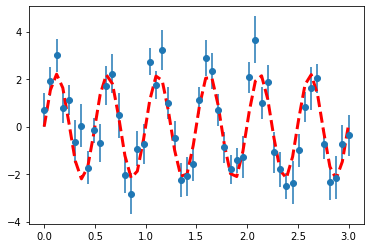

In [32]:
plt.errorbar(x, y, yerr=yerr,fmt='o')
plt.plot(x, yfit,'r--',lw=3)

## Now it is your turn
You are studying the growth rate of an alien bacterial colony. Create and fit data for $y = A*e^{t/\lambda}$ where $A = 10$, $\lambda = 100s$, and $\sigma=40$ with 20 data points. t goes from 0 to 400s. Give your fitted parameters, $\lambda$ and A, plus errorbars. Plot your fit and data on the same plot.

In [33]:
func = lambda t, A, l: A*np.exp(t/l)

num = 20
A, lam, sigma = 10, 100, 40
t = np.linspace(0,400,num) #Create a evenly spaced set of data points

theory_y = func(t, A,lam)
shift = sigma*np.ones(num) * np.random.standard_normal(num)
y = shift + theory_y #Move my y values by the error

(param,cov) = curve_fit(func,t,y,p0=[20,120],sigma=yerr)

plt.errorbar(t, y, yerr=yerr,fmt='o')
plt.plot(t, yfit,'r--',lw=3)
primt(f"A= {param[0]:.2f}, lambda= {param[1]:.2f}")

ValueError: `sigma` has incorrect shape.

How long did it take you to complete this homework?

~ 1 hour